In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
import torchaudio

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import pylab as plt

In [ ]:
# unpacked small.tar downloaded from:
# https://github.com/facebookresearch/libri-light/blob/main/data_preparation/README.md
datadir = Path('/mnt/small/')

In [ ]:
def load(fname, newsr=24000):
    x, sr = torchaudio.load(fname)
    _tform = torchaudio.transforms.Resample(sr, newsr)
    return _tform(x).cuda().unsqueeze(0)

# Distill Whisper with a RQ bottleneck

In [ ]:
speakers = [1649, 2156, 1901, 2607, 2234, 1743, 1614, 3657, 204, 3488, 19, 107, 2162, 1212, 4174]

In [ ]:
# load all embeddings
frames = []
tokens = []
speakerids = []
mb = master_bar(speakers)
for spkid in mb:
    for name in progress_bar(list(Path(f'/mnt/whisper-distil/whisper-tiny-decoder-{spkid}').rglob('*.whisper')), parent=mb):
        frames.append(torch.load(name))
        tokens += torch.load(name.with_suffix('.tokens'))
        speakerids.append(spkid)

frames = torch.cat(frames)
frames.shape

torch.Size([18202, 1, 1500, 384])

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')

In [ ]:
# the total token count (keep in mind we have 50k+ unique tokens...)
sum([len(t) for t in tokens])

1701133

In [ ]:
# the audio length (in hours)
frames.shape[0] * 30 / 60 / 60

151.68333333333334

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class PseudoVQ():
    pass
    
class RQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, q_depth=12, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(RQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.rq = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= q_depth,
        )
        
        self.ce_lossf = nn.CrossEntropyLoss()
        self.kl_lossf = nn.KLDivLoss(reduction='batchmean')

        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)

    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.rq(x)
        self.commit_loss = self.commit_loss.mean()
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        if tokens is not False:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                whmodel.eval()
                teacher_logits = whmodel.decoder(ts, xin)
                whmodel.train()
            logits = whmodel.decoder(ts, x)
            self.ce_loss = self.ce_lossf(logits.view(-1,logits.shape[-1]), torch.tensor(tokens + [tokenizer.eot]).cuda().view(-1))
            self.kl_loss = kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))
            loss = self.ce_loss + self.kl_loss + self.commit_loss
            return x, loss
        else:
            return x

### Optimize data loading

In [ ]:
# slow
for i in progress_bar(list(range(len(frames)))):
    frames[i].to(torch.float32).cuda()

In [ ]:
# fast
for i in progress_bar(list(range(len(frames)))):
    frames[i].cuda().to(torch.float32)

### Measure model forward pass

In [ ]:
xs, ys = frames[1].cuda().to(torch.float32), torch.tensor(tokens[1]).cuda().unsqueeze(0)

In [ ]:
for i in progress_bar(list(range(len(frames)))):
    whmodel.decoder(ys, xs)

### Optimize loss functions

In [ ]:
teacher_logits = whmodel.decoder(ys, xs)

In [ ]:
logits = whmodel.decoder(ys, vqmodel(xs))

In [ ]:
logits.shape, ys.shape

(torch.Size([1, 84, 51864]), torch.Size([1, 84]))

In [ ]:
# terribly slow
ce_lossf = nn.CrossEntropyLoss()
for i in progress_bar(list(range(len(frames[::10])))):
    ce_lossf(logits.permute(0,2,1), ys)

In [ ]:
# crazy fast
ce_lossf = nn.CrossEntropyLoss()
for i in progress_bar(list(range(len(frames[::10])))):
    ce_lossf(logits.view(-1,logits.shape[-1]), ys.view(-1))

In [ ]:
# same results
ce_lossf(logits.view(-1,logits.shape[-1]), ys.view(-1))

tensor(11.5513, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
ce_lossf(logits.permute(0,2,1), ys)

tensor(11.5513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [ ]:
kl_lossf = nn.KLDivLoss(reduction='batchmean')
for i in progress_bar(list(range(len(frames)))):
    kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))

### Optimized training code

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.01, Loss=nn.L1Loss(), lr=1e-4, weight_decay=0.1, epochs=10, scheduler=None):
    all_params = set(vqmodel.parameters())
    wd_params = set()
    for m in vqmodel.modules():
        if isinstance(m, nn.Linear):
            wd_params.add(m.weight)
            if m.bias is not None:
                wd_params.add(m.bias)
    no_wd_params = all_params - wd_params
    
    optimizer = torch.optim.AdamW(lr=lr, betas=(0.9, 0.95), #fused=True,
        params=[
            {"params": list(wd_params), "weight_decay": weight_decay},
            {"params": list(no_wd_params), "weight_decay": 0.0},
        ]
    )

    idxs = list(range(len(xs)))
    random.shuffle(idxs)
    val_n = int(split * len(idxs))
    train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]
    run_valid_every_iters = len(train_idxs)//30

    q_depth = len(vqmodel.rq.layers)
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
    vq_gs = gs[1].subgridspec(1, q_depth)
    codebook_gs = gs[2].subgridspec(1, q_depth)
    graph_fig = plt.figure(figsize=(10,6))
    loss_p = graph_fig.add_subplot(gs[0])
    vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(q_depth)]
    codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(q_depth)]
    graph_out = display(graph_fig, display_id=True, clear=True)
    
    it = 0
    max_vq_usage = [5]*q_depth
    vq_range = torch.tensor([-2,2,-2,2]).repeat(q_depth,1)
    its = [torch.nan]
    train_losses = [torch.nan]
    val_losses = [torch.nan]
    commit_loss = torch.nan
    ce_loss = torch.nan
    kl_loss = torch.nan
    mb = master_bar(range(epochs))
    mb.write(["train", "val"], table=True)
    running_loss = [0]
    for epoch in mb:
        val_loss = 0
        bar = progress_bar(train_idxs, parent=mb)
        for step,i in enumerate(bar):
            # zero the parameter gradients
            optimizer.zero_grad()

            ps, loss = vqmodel(xs[i].cuda().to(torch.float32), ys[i])
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
            running_loss = running_loss[-100:]
            if it % run_valid_every_iters == 50:
                its.append(it)
                train_losses.append(sum(running_loss)/len(running_loss))
                vqmodel.eval()
                with torch.no_grad():
                    loss = 0
                    commit_loss = 0
                    ce_loss = 0
                    kl_loss = 0
                    for i in val_idxs:
                        ps, _loss = vqmodel(xs[i].cuda().to(torch.float32), ys[i])
                        loss += _loss
                        commit_loss += vqmodel.commit_loss
                        ce_loss += vqmodel.ce_loss
                        kl_loss += vqmodel.kl_loss
                    N = len(val_idxs)
                    loss /= loss.item() / N; commit_loss /= commit_loss.item() / N; ce_loss = ce_loss.item() / N; kl_loss = kl_loss.item() / N;
                vqmodel.train()
                val_losses.append(loss)
                loss_p.clear()
                loss_p.plot(its, train_losses)
                loss_p.plot(its, val_losses)
                loss_p.set_xlim(0, epochs * len(train_idxs))
                loss_p.set_yscale('log')
                for i in range(q_depth):
                    vq = vqmodel.rq.layers[i]
                    cls = vq._codebook.cluster_size
                    vq_p[i].clear()
                    vq_p[i].fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
                    vq_p[i].margins(0,0)
                    vq_p[i].spines['top'].set_visible(False)
                    vq_p[i].spines['right'].set_visible(False)
                    vq_p[i].spines['bottom'].set_visible(False)
                    vq_p[i].spines['left'].set_visible(False)
                    vq_p[i].set_ylim(0, max_vq_usage[i])
                    used_codes = (cls > 0.1).sum()
                    vq_p[i].text(0.5, 0.9, f'{int(used_codes)}', horizontalalignment='center',
                         verticalalignment='center', transform=vq_p[i].transAxes)
                    cd = vq._codebook.embed
                    codebook_p[i].clear()
                    codebook_p[i].scatter(vq.codebook[:,0].cpu(), vq.codebook[:,1].cpu(), s=vq._codebook.cluster_size.cpu(), alpha=.2)
                    codebook_p[i].set_xlim(*vq_range[i][0:2])
                    codebook_p[i].set_ylim(*vq_range[i][2:4])
                graph_out.update(graph_fig)

            it += 1
            bar.comment = f"#{epoch+1}/{epochs} loss: {sum(running_loss) / len(running_loss):.3f} / {val_losses[-1]:.3f} commit: {commit_loss:.3f} ce: {ce_loss:.3f} kl: {kl_loss:.3f}"
        mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}"], table=True)
    graph_out.update(IPython.display.HTML(''))

### Optimize hyperparameters

train,val
410.636,394.554
402.106,386.052
218.702,213.494
153.864,144.065
138.302,119.512


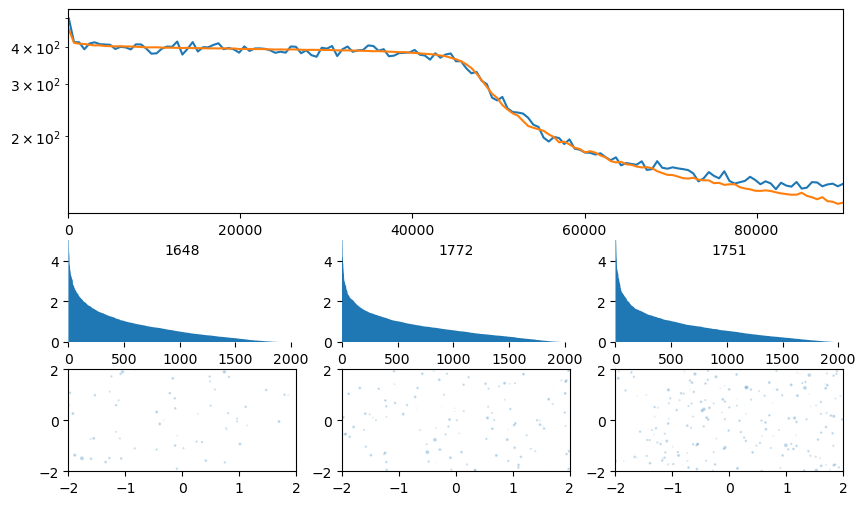

In [ ]:
# 2 layers
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=2,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5)

train,val
394.059,396.623
387.102,387.631
259.283,262.650
207.640,206.711
192.755,180.985


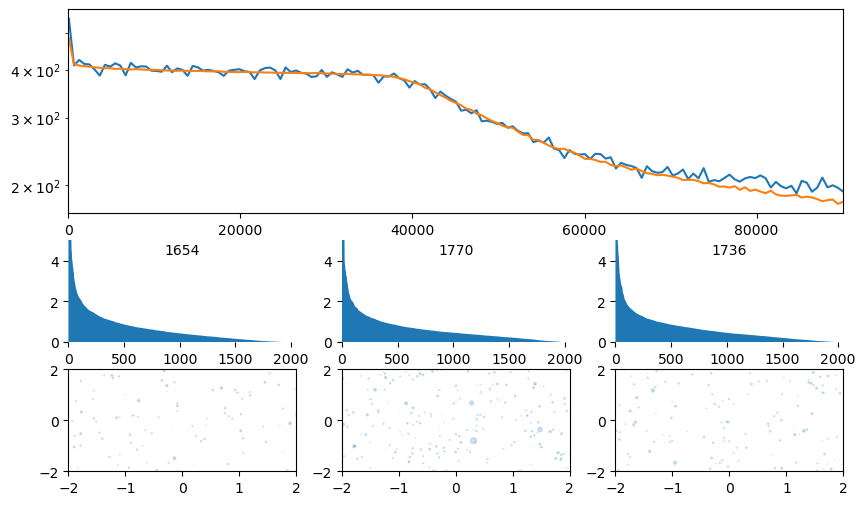

In [ ]:
# 1 layer
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5)

train,val
390.764,393.241
390.506,386.932
363.965,370.650
256.359,260.999
220.977,211.773


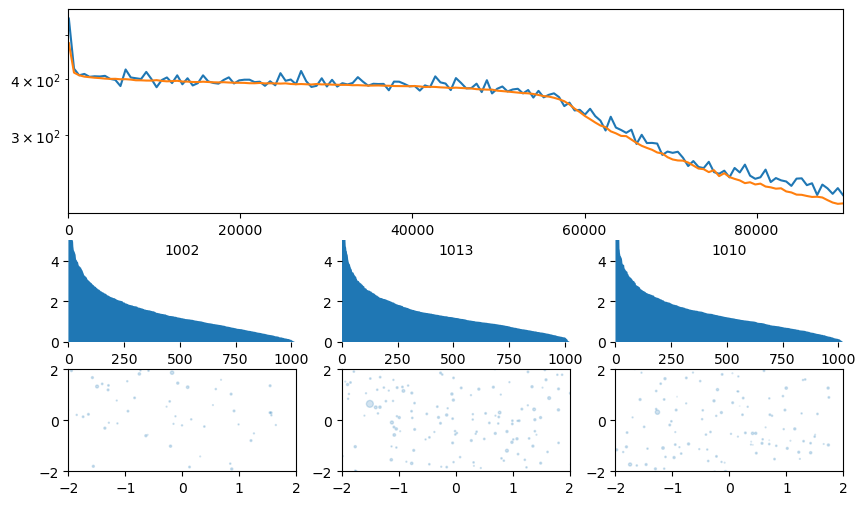

In [ ]:
# 1024 codes x 3 = 30 bits
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5)

train,val
390.292,391.117
384.376,387.732
396.527,384.745
394.728,382.765
394.189,378.432


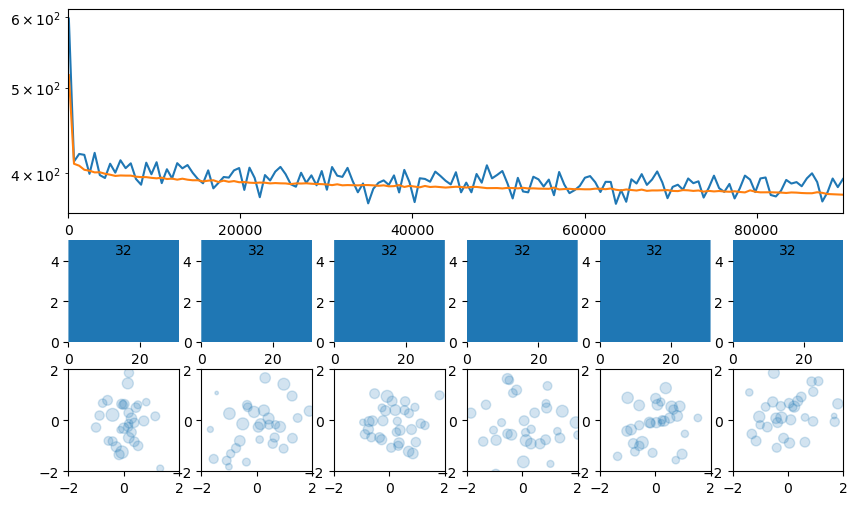

In [ ]:
# 32 codes * 6 = 30 bits
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=32, q_depth=6, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5)

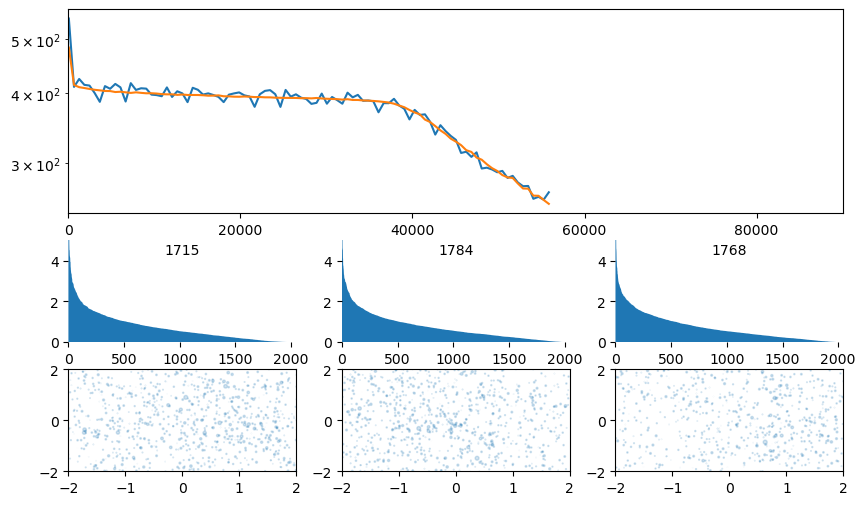

train,val
394.059,396.623
387.102,387.631
259.283,262.650


In [ ]:
# 2 layers, 1024 codes (no as good as 2048)
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=3, n_head=6, depth=2,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5)

### Add warmup and LR schedule

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.01, Loss=nn.L1Loss(), lr=1e-4, weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10, scheduler=None):
    all_params = set(vqmodel.parameters())
    wd_params = set()
    for m in vqmodel.modules():
        if isinstance(m, nn.Linear):
            wd_params.add(m.weight)
            if m.bias is not None:
                wd_params.add(m.bias)
    no_wd_params = all_params - wd_params
    
    optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
        params=[
            {"params": list(wd_params), "weight_decay": weight_decay},
            {"params": list(no_wd_params), "weight_decay": 0.0},
        ]
    )

    idxs = list(range(len(xs)))
    random.shuffle(idxs)
    val_n = int(split * len(idxs))
    train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]
    run_valid_every_iters = len(train_idxs)//30

    q_depth = len(vqmodel.rq.layers)
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
    vq_gs = gs[1].subgridspec(1, q_depth)
    codebook_gs = gs[2].subgridspec(1, q_depth)
    graph_fig = plt.figure(figsize=(10,6))
    loss_p = graph_fig.add_subplot(gs[0])
    vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(q_depth)]
    codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(q_depth)]
    graph_out = display(graph_fig, display_id=True, clear=True)
    
    it = 0
    max_vq_usage = [5]*q_depth
    vq_range = torch.tensor([-2,2,-2,2]).repeat(q_depth,1)
    its = [torch.nan]
    train_losses = [torch.nan]
    val_losses = [torch.nan]
    commit_loss = torch.nan
    ce_loss = torch.nan
    kl_loss = torch.nan
    mb = master_bar(range(epochs))
    mb.write(["train", "val"], table=True)
    running_loss = [0]
    for epoch in mb:
        val_loss = 0
        bar = progress_bar(train_idxs, parent=mb)
        for step,i in enumerate(bar):
            # zero the parameter gradients
            optimizer.zero_grad()

            ps, loss = vqmodel(xs[i].cuda().to(torch.float32), ys[i])
            loss.backward()
            optimizer.step()
            if it == warmup:
                scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(xs), epochs=epochs)
            if it > warmup:
                # warmup
                scheduler.step()

            running_loss.append(loss.item())
            running_loss = running_loss[-100:]
            if it % run_valid_every_iters == 50:
                its.append(it)
                train_losses.append(sum(running_loss)/len(running_loss))
                vqmodel.eval()
                with torch.no_grad():
                    loss = 0
                    commit_loss = 0
                    ce_loss = 0
                    kl_loss = 0
                    for i in val_idxs:
                        ps, _loss = vqmodel(xs[i].cuda().to(torch.float32), ys[i])
                        loss += _loss
                        commit_loss += vqmodel.commit_loss
                        ce_loss += vqmodel.ce_loss
                        kl_loss += vqmodel.kl_loss
                    N = len(val_idxs)
                    loss = loss.item() / N; commit_loss = commit_loss.item() / N; ce_loss = ce_loss.item() / N; kl_loss = kl_loss.item() / N;
                vqmodel.train()
                val_losses.append(loss)
                loss_p.clear()
                loss_p.plot(its, train_losses)
                loss_p.plot(its, val_losses)
                loss_p.set_xlim(0, epochs * len(train_idxs))
                loss_p.set_yscale('log')
                for i in range(q_depth):
                    vq = vqmodel.rq.layers[i]
                    cls = vq._codebook.cluster_size
                    vq_p[i].clear()
                    vq_p[i].fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
                    vq_p[i].margins(0,0)
                    vq_p[i].spines['top'].set_visible(False)
                    vq_p[i].spines['right'].set_visible(False)
                    vq_p[i].spines['bottom'].set_visible(False)
                    vq_p[i].spines['left'].set_visible(False)
                    vq_p[i].set_ylim(0, max_vq_usage[i])
                    used_codes = (cls > 0.1).sum()
                    vq_p[i].text(0.5, 0.9, f'{int(used_codes)}', horizontalalignment='center',
                         verticalalignment='center', transform=vq_p[i].transAxes)
                    cd = vq._codebook.embed
                    codebook_p[i].clear()
                    codebook_p[i].scatter(vq.codebook[:,0].cpu(), vq.codebook[:,1].cpu(), s=vq._codebook.cluster_size.cpu(), alpha=.2)
                    codebook_p[i].set_xlim(*vq_range[i][0:2])
                    codebook_p[i].set_ylim(*vq_range[i][2:4])
                graph_out.update(graph_fig)

            it += 1
            bar.comment = f"#{epoch+1}/{epochs} loss: {sum(running_loss) / len(running_loss):.3f} / {val_losses[-1]:.3f} commit: {commit_loss:.3f} ce: {ce_loss:.3f} kl: {kl_loss:.3f}"
        mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}"], table=True)
    graph_out.update(IPython.display.HTML(''))

train,val
407.057,387.873
160.491,98.757
91.048,46.711
70.389,34.727
63.228,32.123


/home/user/miniconda3/envs/jupyter-new/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


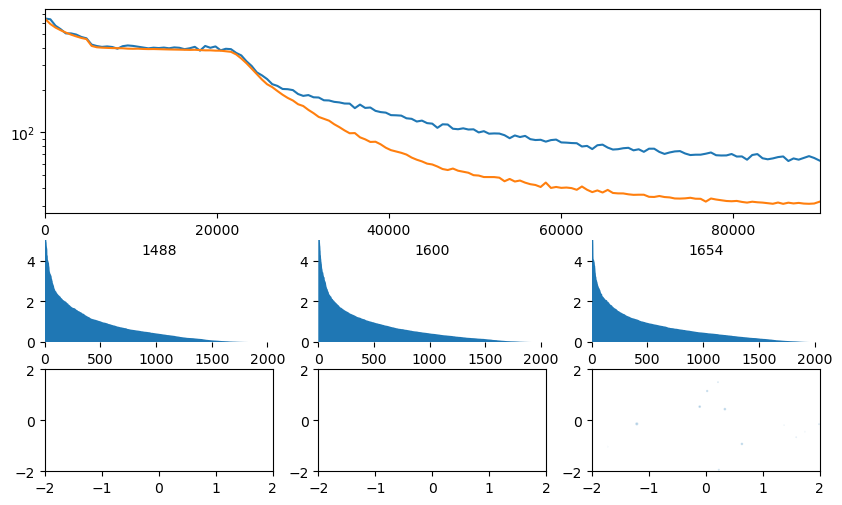

In [ ]:
# warmup does wonders!
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-4, warmup_mul=1e-3)

### Verify the decoder output

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), frames[0].cuda()).argmax(-1)[0])

'<|nospeech|> CHAPTER 1. Of American History Stories. Volume 1 This is a LibraVox recording. All LibraVox recordings are in the public domain. For more information or development here, please visit LibraVox.org. Recording by Kalinda. American History Stories, Volume 1 By Mar-L Pratt CHAPTER 1 Long ago<|endoftext|>'

In [ ]:
# almost perfect
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), vqmodel(frames[0].cuda().to(torch.float32))).argmax(-1)[0])

'<|nospeech|> CHAPTER 1 of Of American History Stories, Volume 1 This is a LibraVox recording. All LibraVox recordings are in the public domain. For more information or to here, please visit LibraVox.org. Recording by Coinda. American History Stories, Volume 1 By MarrowEl- CHAPTER 1 Long ago<|endoftext|>'

train,val
401.566,387.518
158.741,94.326
109.932,52.622
89.118,41.986
81.207,38.316


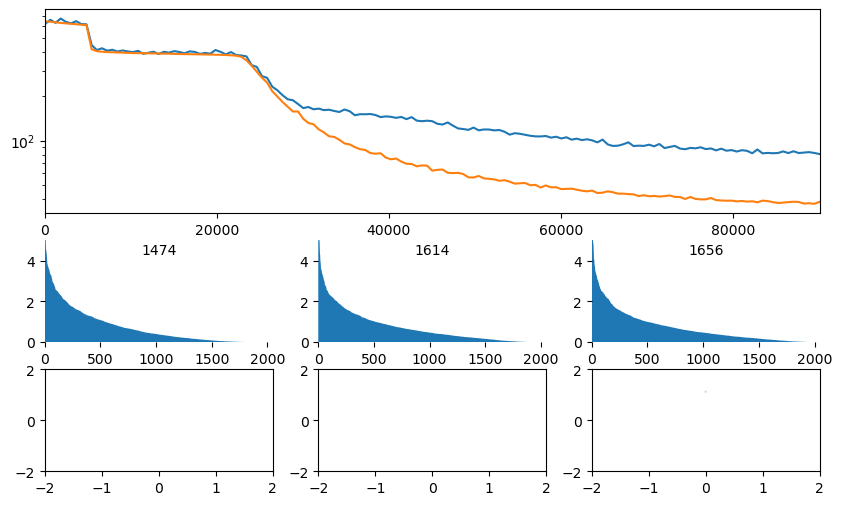

In [ ]:
# these are strange parameters to try but I did it because I had a bug in the training code... ;)
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-4, warmup_mul=1e-8)

train,val
394.756,403.774
386.133,395.916
394.959,392.425
387.532,390.600
384.790,390.066


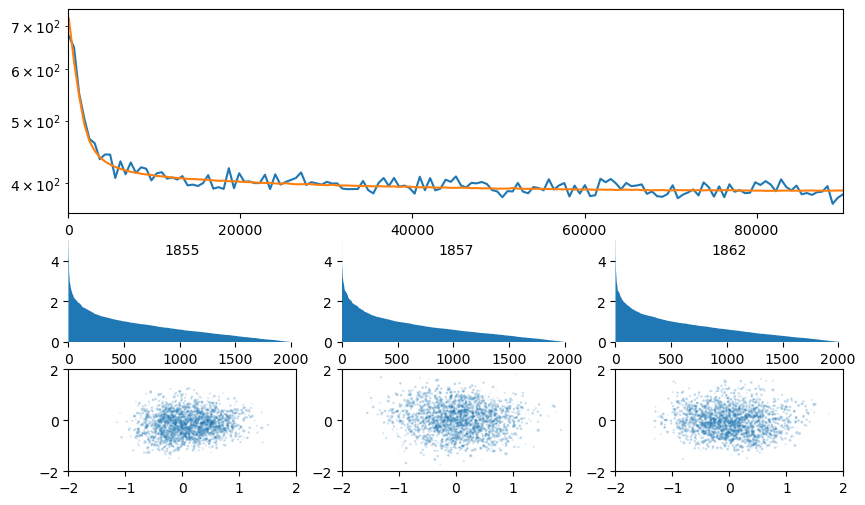

In [ ]:
# One more test with no warmup, terrible
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=5e-6, warmup=0)